In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [6]:
# DSP data
fpath = "../../data/DNN_data/"

sig = np.load(fpath + "data_signal" + ".npy")
artifact = np.load(fpath + "data_sine_wave" + ".npy")
sig_with_artifact = sig + artifact

sig_with_artifact.shape

(4000, 2)

Text(0.5, 1.0, 'Original Signal')

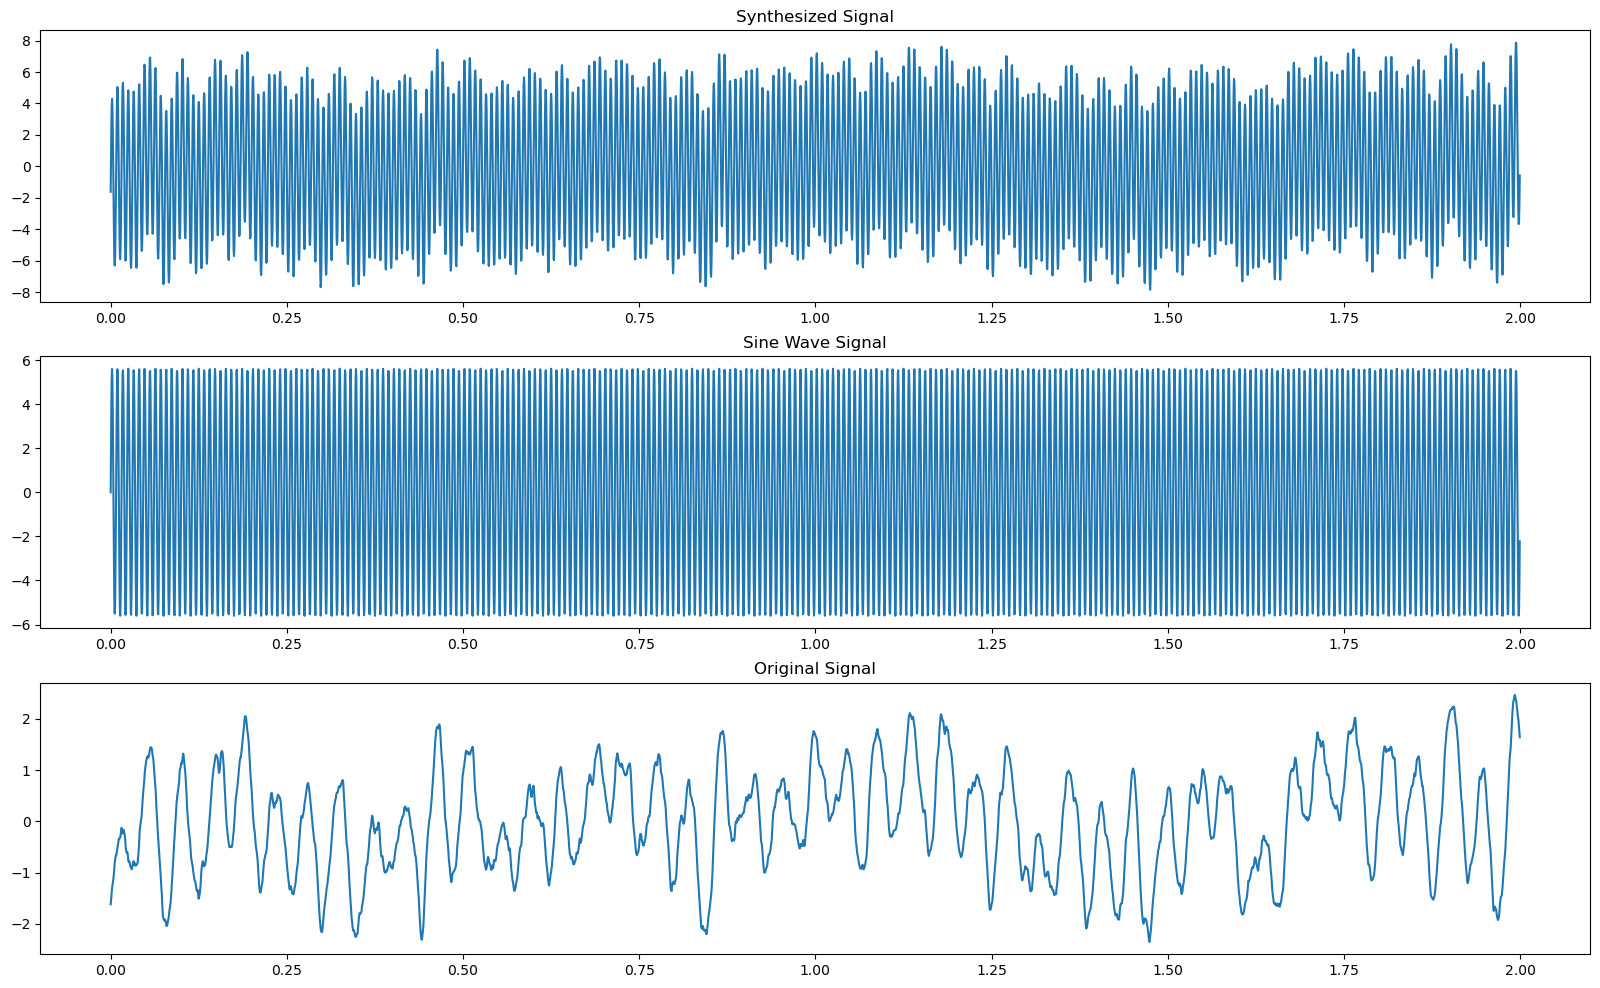

In [3]:
plt.figure(figsize=(20,12))
plt.subplot(3, 1, 1)
plt.plot(data1.iloc[:,0])
plt.title('Synthesized Signal')

plt.subplot(3, 1, 2)
plt.plot(data2.iloc[:,0])
plt.title('Sine Wave Signal')

plt.subplot(3, 1, 3)
plt.plot(data3.iloc[:,0])
plt.title('Original Signal')

In [4]:
# 정규화
scaler = MinMaxScaler()
df1 = scaler.fit_transform(data1).transpose()
df2 = scaler.fit_transform(data3).transpose()

df1.shape, df2.shape

((1000, 4000), (1000, 4000))

In [5]:
X = df1
y = df2

X.shape, y.shape

((1000, 4000), (1000, 4000))

In [6]:
# 훈련 세트와 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#PyTorch Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_train.shape, y_train.shape

(torch.Size([800, 4000]), torch.Size([800, 4000]))

In [7]:
X_train = X_train.unsqueeze(1) # 배치수, 채널, Row
y_train = y_train.unsqueeze(1)

X_val = X_val.unsqueeze(1)
y_val = y_val.unsqueeze(1)

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 3, padding=1)  # Maintain length
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 1, 3, padding=1)  # Output layer to match input dimensions
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        return x

In [9]:
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs = 100

for epoch in range(num_epochs):
    for i,(train_, label_) in enumerate(dataloader):        
        optimizer.zero_grad()
        y_pred = model(train_)
        loss = criterion(y_pred,label_)
        loss.backward()
        optimizer.step()
    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/100, Loss: 0.028084121644496918
Epoch 10/100, Loss: 0.016695091500878334
Epoch 15/100, Loss: 0.0065749334171414375
Epoch 20/100, Loss: 0.0044032251462340355
Epoch 25/100, Loss: 0.0043491520918905735
Epoch 30/100, Loss: 0.0041672964580357075
Epoch 35/100, Loss: 0.003958734683692455
Epoch 40/100, Loss: 0.0038999407552182674
Epoch 45/100, Loss: 0.004086202941834927
Epoch 50/100, Loss: 0.0036899123806506395
Epoch 55/100, Loss: 0.003362571354955435
Epoch 60/100, Loss: 0.003546475898474455
Epoch 65/100, Loss: 0.003162625478580594
Epoch 70/100, Loss: 0.003343498334288597
Epoch 75/100, Loss: 0.002899907296523452
Epoch 80/100, Loss: 0.0030653795693069696
Epoch 85/100, Loss: 0.003288175677880645
Epoch 90/100, Loss: 0.0030258509796112776
Epoch 95/100, Loss: 0.0030450241174548864
Epoch 100/100, Loss: 0.002637981902807951


In [10]:
# 모델 평가
model.eval()
with torch.no_grad():
    val_outputs = model(X_val)
    val_loss = criterion(val_outputs, y_val)
    print(f'Validation Loss: {val_loss.item():.4f}')

Validation Loss: 0.0031


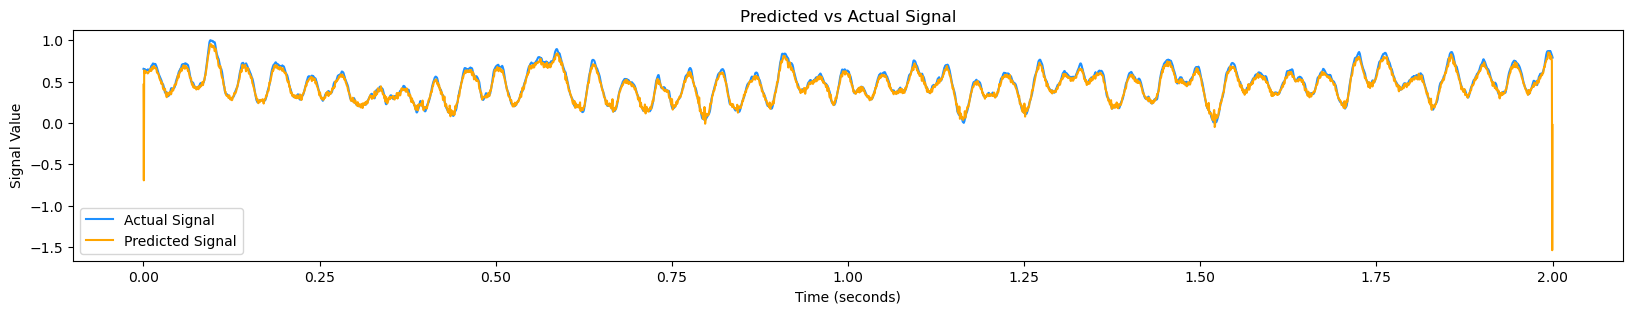

In [11]:
val_outputs1 = val_outputs.view(200, 4000).numpy()
y_val1 = y_val.view(200, 4000).numpy()

predicted_signal = val_outputs1[0]
actual_signal = y_val1[0]

# 타임 스텝을 시간 단위로 변환
time_steps = np.linspace(0, 2, num=4000)  

plt.figure(figsize=(20, 3))
plt.plot(time_steps, actual_signal, label='Actual Signal', color='dodgerblue')
plt.plot(time_steps, predicted_signal, label='Predicted Signal', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal Value')
plt.title('Predicted vs Actual Signal')
plt.legend()
plt.show()

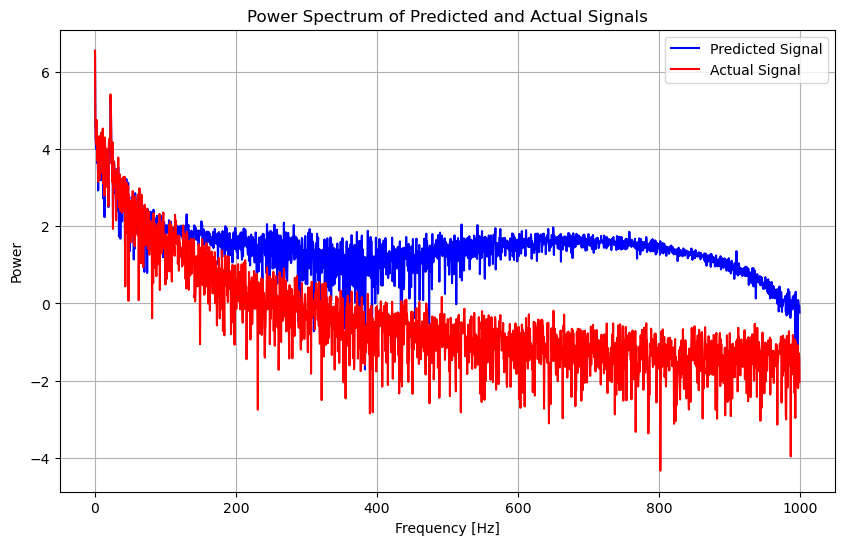

In [12]:
n = len(predicted_signal)

fs = 2000
freqs = np.fft.fftfreq(n, d=1/fs)[:n//2]

fft_predicted = np.fft.fft(predicted_signal)
fft_predicted = np.abs(fft_predicted[:n//2])
fft_predicted[1:] = 2 * fft_predicted[1:]
power_predicted = fft_predicted**2

fft_actual = np.fft.fft(actual_signal)
fft_actual = np.abs(fft_actual[:n//2])
fft_actual[1:] = 2 * fft_actual[1:]
power_actual = fft_actual**2

# 결과 플로팅
plt.figure(figsize=(10, 6))
plt.plot(freqs, np.log10(power_predicted), label='Predicted Signal', color='blue')
plt.plot(freqs, np.log10(power_actual), label='Actual Signal', color='red')
plt.title('Power Spectrum of Predicted and Actual Signals')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()